In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import Input
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(2)

In [2]:
dataframe = pd.read_csv('dataframe.csv')
dataframe

,Unnamed: 0,ID,etmiss,mtw,leadleptPt,leadleptEta,leadleptE,leadleptPhi,Q_leadlep,leadleptID,...,ttbarMLR,largeRjet_pt_total,largeRjet_eta_total,largeRjet_phi_total,largeRjet_m_total,largeRjet_tau32_total,weight,scale,label,scaleweight
0,0,signal,284.0070,51.4513,158.2950,0.125750,159.5480,0.246570,-1,13,...,616.923,434.907,0.003795,-3.105850,172.235,0.263504,0.000000,0.056722,1,0.000000
1,1,signal,194.7950,100.9790,58.2204,-0.676782,72.0706,-0.338934,1,11,...,571.721,373.238,0.031308,-2.606120,158.346,0.462140,0.000000,0.056722,1,0.000000
2,2,signal,248.7820,68.8350,44.5272,-0.311100,46.6994,3.066820,-1,11,...,536.674,403.840,0.685499,0.631162,175.933,0.290648,0.000000,0.056722,1,0.000000
3,3,signal,98.7296,19.8922,261.8510,0.385745,281.5750,-2.184720,1,13,...,921.435,472.371,0.048611,0.576137,223.665,0.428973,0.000000,0.056722,1,0.000000
4,4,signal,248.7050,32.9140,149.7410,1.617440,392.2160,-1.361590,1,11,...,853.772,420.366,0.136872,1.328520,121.342,0.496269,0.002304,0.056722,1,0.000131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252091,252091,lepton_bkg,232.9160,16.1447,53.0237,-0.827826,72.2537,-2.364720,1,11,...,0.000,327.821,1.144510,0.510144,123.086,0.670010,0.167915,0.018804,0,0.003157
252092,252092,lepton_bkg,234.3410,68.3447,43.5060,0.293652,45.3953,-2.418000,-1,11,...,697.808,344.195,1.116320,1.200730,115.454,0.668324,0.141649,0.018804,0,0.002664
252093,252093,lepton_bkg,120.0420,98.2329,38.0663,1.822840,120.8800,2.297760,1,13,...,0.000,713.254,0.580453,0.511460,119.566,0.691067,0.209875,0.018804,0,0.003946
252094,252094,lepton_bkg,143.3440,155.8760,70.7158,-0.114848,71.1828,-2.978210,1,13,...,0.000,836.475,-0.616361,2.270880,242.974,1.260570,0.088000,0.018804,0,0.001655


In [3]:
dataframe.columns

Index(['Unnamed: 0', 'ID', 'etmiss', 'mtw', 'leadleptPt', 'leadleptEta',
       'leadleptE', 'leadleptPhi', 'Q_leadlep', 'leadleptID', 'n_TopLRjets',
       'leadTopLRjet_pt', 'leadTopLRjet_eta', 'leadTopLRjet_phi',
       'leadTopLRjet_m', 'leadTopLRjet_Tau32', 'n_jets', 'leadjet_pt',
       'leadjet_eta', 'n_bjets', 'leadbjet_pt', 'leadbjet_eta', 'ttbarMLR',
       'largeRjet_pt_total', 'largeRjet_eta_total', 'largeRjet_phi_total',
       'largeRjet_m_total', 'largeRjet_tau32_total', 'weight', 'scale',
       'label', 'scaleweight'],
      dtype='object')

In [4]:
train_features = ['etmiss', 'mtw', 'leadleptPt', 'leadleptEta',
       'leadleptE', 'leadleptPhi', 'Q_leadlep', 'leadleptID', 'n_TopLRjets',
       'leadTopLRjet_pt', 'leadTopLRjet_eta', 'leadTopLRjet_phi',
       'leadTopLRjet_m', 'leadTopLRjet_Tau32', 'n_jets', 'leadjet_pt',
       'leadjet_eta', 'n_bjets', 'leadbjet_pt', 'leadbjet_eta', 'ttbarMLR']
label = 'label'
train_weight = "scaleweight"

In [5]:
scaler = StandardScaler()
scaler.fit(dataframe[train_features].values)

x = scaler.transform(dataframe[train_features].values)
y = dataframe[label].values
w = dataframe[train_weight].values

x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(x, y, w, test_size=0.2, random_state=42)



"""
x_val = scaler.transform(data_val[train_features].values)
y_val = data_val[label].values
w_val = data_val[train_weight].values

x_test = scaler.transform(data_test[train_features].values)
y_test = data_test[label].values
w_test = data_test[train_weight].values
"""

'\nx_val = scaler.transform(data_val[train_features].values)\ny_val = data_val[label].values\nw_val = data_val[train_weight].values\n\nx_test = scaler.transform(data_test[train_features].values)\ny_test = data_test[label].values\nw_test = data_test[train_weight].values\n'

In [6]:
# your answer
model = Sequential([Input(shape=(x_train.shape[1],))])

# Input and Hidden layers

model.add(Dense(80, activation='relu'))
model.add(Dense(95, activation='relu'))
model.add(Dense(70, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=8e-4), weighted_metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 95)             │         7,695 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 70)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,246 (63.46 KB)

 Trainable params: 16,246 (63.46 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(x_train, y_train, sample_weight=w_train, validation_data=(x_val, y_val, w_val), epochs=100, batch_size=1024, callbacks=[EarlyStopping(patience=3)])

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9575 - loss: 0.0125 - val_accuracy: 0.9737 - val_loss: 0.0073
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0075 - val_accuracy: 0.9737 - val_loss: 0.0071
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0073 - val_accuracy: 0.9737 - val_loss: 0.0070
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0072 - val_accuracy: 0.9737 - val_loss: 0.0069
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0071 - val_accuracy: 0.9737 - val_loss: 0.0069
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0071 - val_accuracy: 0.9737 - val_loss: 0.0068
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0070 - val_accuracy: 0.9737 - val_loss: 0.0068
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0069 - val_accu

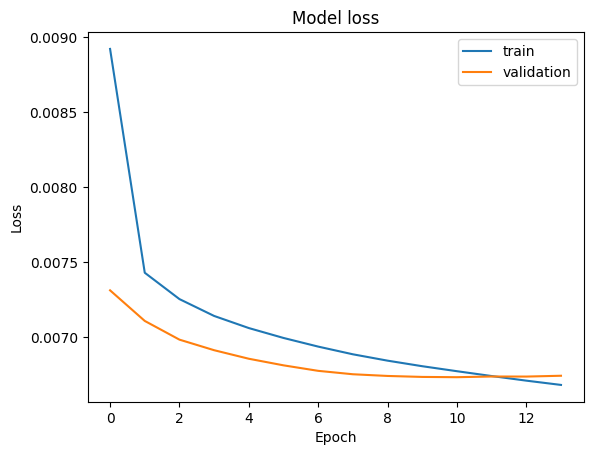

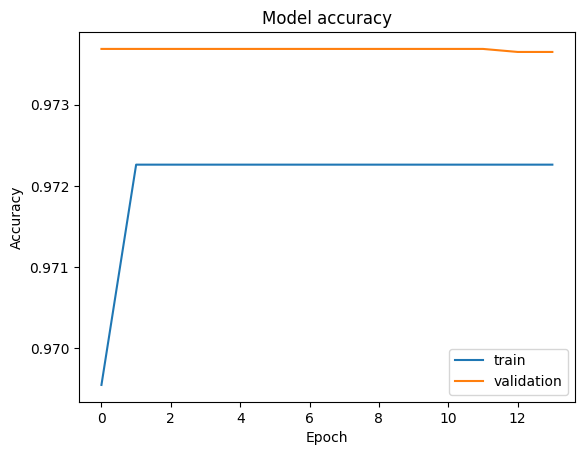

In [8]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6303/6303 ━━━━━━━━━━━━━━━━━━━━ 1s 192us/step
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step


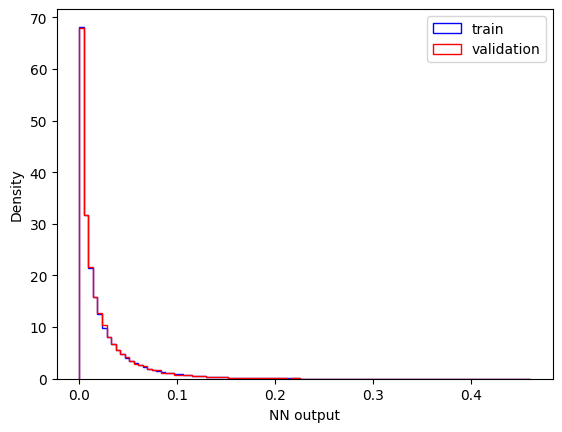

In [9]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

bin = plt.hist(y_train_pred, bins=100, density=True, histtype='step', color='blue', label='train')
plt.hist(y_val_pred, bins=bin[1], density=True, histtype='step', color='red', label='validation')

plt.xlabel('NN output')
plt.ylabel('Density')
plt.legend()

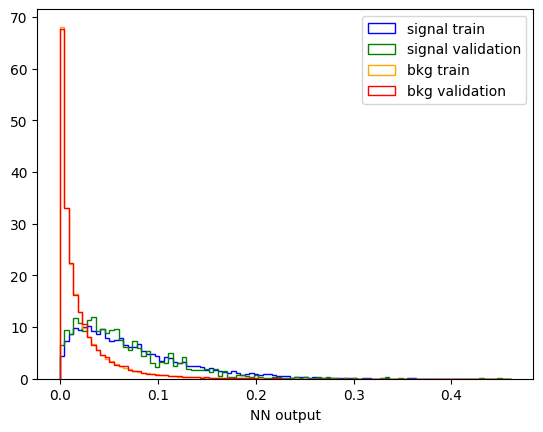

In [10]:
# your answer
bins = plt.hist(y_train_pred[y_train==1], bins=100, density=True, histtype='step', color='blue', label='signal train')
plt.hist(y_val_pred[y_val==1], bins=bins[1], density=True, histtype='step', color='green', label='signal validation')
plt.hist(y_train_pred[y_train==0], bins=bins[1], density=True, histtype='step', color='orange', label='bkg train')
plt.hist(y_val_pred[y_val==0], bins=bins[1], density=True, histtype='step', color='red', label='bkg validation')

plt.xlabel('NN output')
plt.legend()
plt.show()


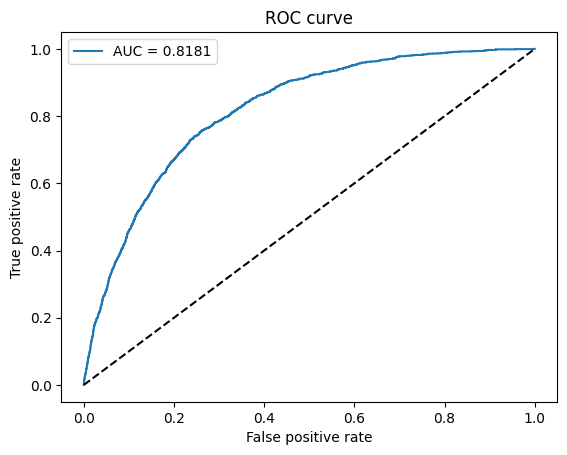

In [11]:
# RPC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

7878/7878 ━━━━━━━━━━━━━━━━━━━━ 2s 193us/step


/var/folders/0f/g4_t3r9d0nd2ht__gmq9q52m0000gn/T/ipykernel_19859/2483734878.py:2: RuntimeWarning: invalid value encountered in scalar divide
  sig = s/np.sqrt(s+b)
/var/folders/0f/g4_t3r9d0nd2ht__gmq9q52m0000gn/T/ipykernel_19859/2483734878.py:2: RuntimeWarning: invalid value encountered in scalar divide
  sig = s/np.sqrt(s+b)
/var/folders/0f/g4_t3r9d0nd2ht__gmq9q52m0000gn/T/ipykernel_19859/2483734878.py:2: RuntimeWarning: invalid value encountered in scalar divide
  sig = s/np.sqrt(s+b)
/var/folders/0f/g4_t3r9d0nd2ht__gmq9q52m0000gn/T/ipykernel_19859/2483734878.py:2: RuntimeWarning: invalid value encountered in scalar divide
  sig = s/np.sqrt(s+b)
/var/folders/0f/g4_t3r9d0nd2ht__gmq9q52m0000gn/T/ipykernel_19859/2483734878.py:2: RuntimeWarning: invalid value encountered in scalar divide
  sig = s/np.sqrt(s+b)
/var/folders/0f/g4_t3r9d0nd2ht__gmq9q52m0000gn/T/ipykernel_19859/2483734878.py:2: RuntimeWarning: invalid value encountered in scalar divide
  sig = s/np.sqrt(s+b)
/var/folders/0f/

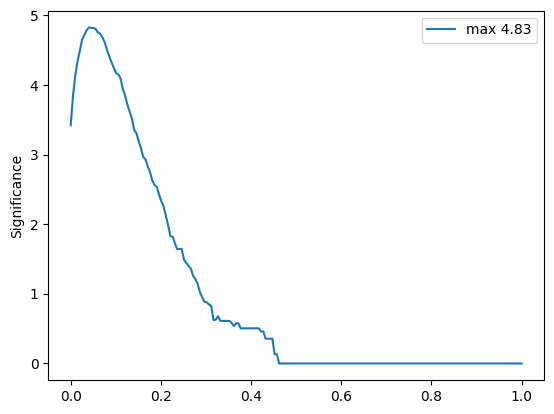

In [25]:
def significance (s,b):
  sig = s/np.sqrt(s+b)
  return sig if not (np.isnan(sig) or np.isinf(sig)) else 0
dataframe['y_pred'] = model.predict(x)

Ncuts = 200
cuts = np.linspace(0,1,Ncuts)
sig  = np.zeros_like(cuts)

for i,cut in enumerate(cuts):

  s = dataframe.loc[dataframe.query(f'(label==1) & (y_pred>{cut})').index,'scaleweight'].sum()
  b = dataframe.loc[dataframe.query(f'(label==0) & (y_pred>{cut})').index,'scaleweight'].sum()
  sig[i] = significance(s,b)
  #print(f'cut {cut:.2f} index {i} signal {s} background {b} significance {sig[i]}')

plt.plot(cuts,sig,label=f'max {max(sig):.2f}')
plt.ylabel('Significance')
plt.legend()
plt.show()